# Number recognition

## Model generation

In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils import to_categorical

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
(X_train,Y_train),(X_test,Y_test) = mnist.load_data()
X_train.shape, X_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

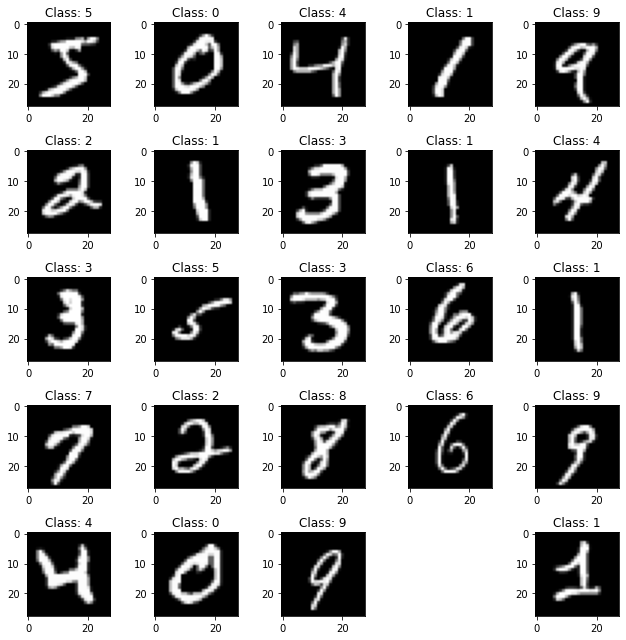

In [ ]:
plt.figure(figsize=(9,9))
for idx in range(25):
  plt.subplot(5,5, idx+1)
  plt.imshow(X_train[idx], cmap='gray')
  plt.title('Class: {}'.format(Y_train[idx]))

  plt.tight_layout()

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

X_train = X_train.reshape(-1, img_rows, img_cols, 1)
X_test = X_test.reshape(-1, img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

In [ ]:
X_train.shape, X_test.shape, input_shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (28, 28, 1))

In [ ]:
if np.max(X_train) >1: X_train = X_train / 255
if np.max(X_test) >1: X_test = X_test / 255

In [ ]:
if len(Y_train.shape)==1:
  num_classes = len(set(Y_train))
  Y_train = to_categorical(Y_train, num_classes)
  Y_test = to_categorical(Y_test, num_classes)

Y_train.shape

(60000, 10)

In [ ]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), input_shape=input_shape),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(filters=64, kernel_size=(3,3)),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(
  X_train, Y_train,
  batch_size=128,
  epochs=3,
  validation_data=(X_test,Y_test)
)

Epoch 1/3
469/469 [==============================] - 49s 105ms/step - loss: 0.1680 - accuracy: 0.9504 - val_loss: 0.0542 - val_accuracy: 0.9832
Epoch 2/3
469/469 [==============================] - 49s 104ms/step - loss: 0.0454 - accuracy: 0.9864 - val_loss: 0.0414 - val_accuracy: 0.9872
Epoch 3/3
469/469 [==============================] - 49s 105ms/step - loss: 0.0293 - accuracy: 0.9907 - val_loss: 0.0415 - val_accuracy: 0.9867


In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
score

[0.041462864726781845, 0.9866999983787537]

In [ ]:
model.save('number_recognition_model.h5')

## Data testing

In [ ]:
from PIL import Image
from math import floor, ceil
from matplotlib import cm


In [ ]:
def predict(img):
  global model
  res = model.predict([img])[0]
  return np.argmax(res), max(res)

def process_img(path_to_img):
  image = Image.open(path_to_img)
  image = image.convert('L')
  image = np.array(image)
  image = image / 255
  new_image = np.zeros((28, 28))
  old_image_rows, old_image_cols = image.shape
  new_image[14- floor(old_image_rows/2):14 + ceil(old_image_rows/2), 14- floor(old_image_cols/2):14 + ceil(old_image_cols/2)] = image
  new_image = new_image.reshape(1, 28, 28, 1)
  new_image[new_image<0.1] = 0
  return new_image

In [ ]:
new_image[new_image<0.1] = 0

In [ ]:
predict(process_img("2.png"))

(2, 0.9981744)

## Model explaining

In [ ]:
!pip install shap

import shap
import numpy as np


     |████████████████████████████████| 327kB 4.2MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463909 sha256=bf9ff8511d7e8448212e29c2aec945b93d24bd0bd8dc827863047dffa4d0b388
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

In [ ]:
processed_images = ["1.png", "2.png", "3.png", "4.png", "5.png", "6.png", "7.png", "8.png", "9.png", "10.png", "11.png", "12.png", "13.png", "14.png", "15.png", "16.png", "17.png", "18.png", "19.png", "20.png", "21.png", "22.png", "23.png", "24.png", "25.png"]
processed_images = np.array(list(map(process_img, processed_images)), dtype=np.float32)
processed_images = processed_images.reshape(25, 28, 28, 1)
processed_images.shape

(25, 28, 28, 1)

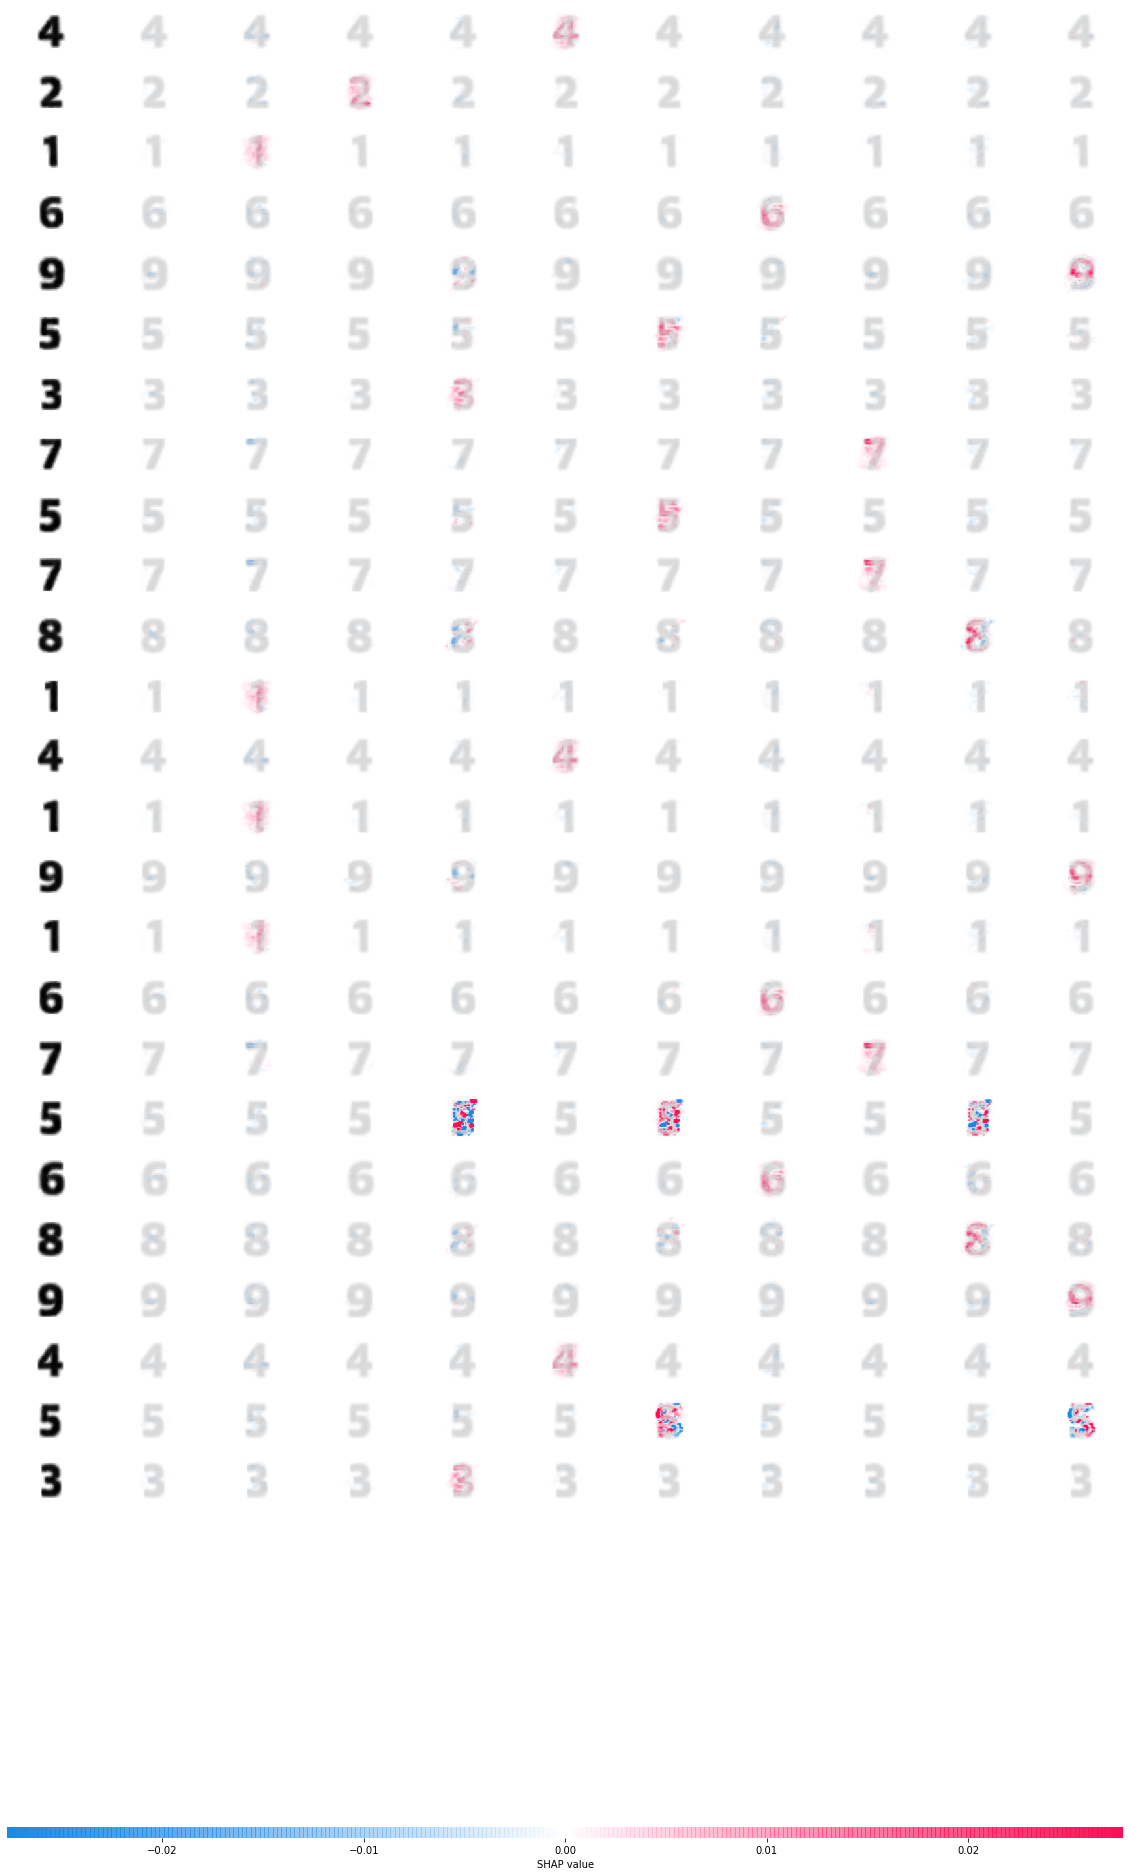

In [ ]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(processed_images)
shap.image_plot(shap_values, -processed_images)